In [0]:
import pandas as pd
import numpy as np
import scipy.sparse 
import scipy

import pickle
from google.colab import files

from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer

# Load Data


In [17]:
!wget -q -N https://www.dropbox.com/s/le0dirljhf1hgi9/ml_latest_small.zip
!unzip -o -q ml_latest_small.zip

!ls *.csv

links.csv  movies.csv  ratings.csv  tags.csv


In [18]:
movies_df = pd.read_csv('movies.csv')
movies_df.shape

(9742, 3)

In [19]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [21]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.shape

(100836, 4)

In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [22]:
links_df = pd.read_csv('links.csv')
links_df.shape

(9742, 3)

# Visualization

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
movies_df['year'] = movies_df.title.str.extract("\((\d{4})\)", expand=True)
movies_df.year = pd.to_datetime(movies_df.year, format='%Y')
movies_df.year = movies_df.year.dt.year 
movies_df.title = movies_df.title.str[:-7]

genres_unique = pd.DataFrame(movies_df.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) 
movies_df = movies_df.join(movies_df.genres.str.get_dummies().astype(bool))
movies_df.drop('genres', inplace=True, axis=1)

In [35]:
movies_df.isnull().sum()

movieId                0
title                  0
year                  13
(no genres listed)     0
Action                 0
Adventure              0
Animation              0
Children               0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Fantasy                0
Film-Noir              0
Horror                 0
IMAX                   0
Musical                0
Mystery                0
Romance                0
Sci-Fi                 0
Thriller               0
War                    0
Western                0
dtype: int64

In [0]:
movies_df.dropna(inplace=True)

In [0]:
movies_df.sort_values(by='movieId', inplace=True)
movies_df.reset_index(inplace=True, drop=True)

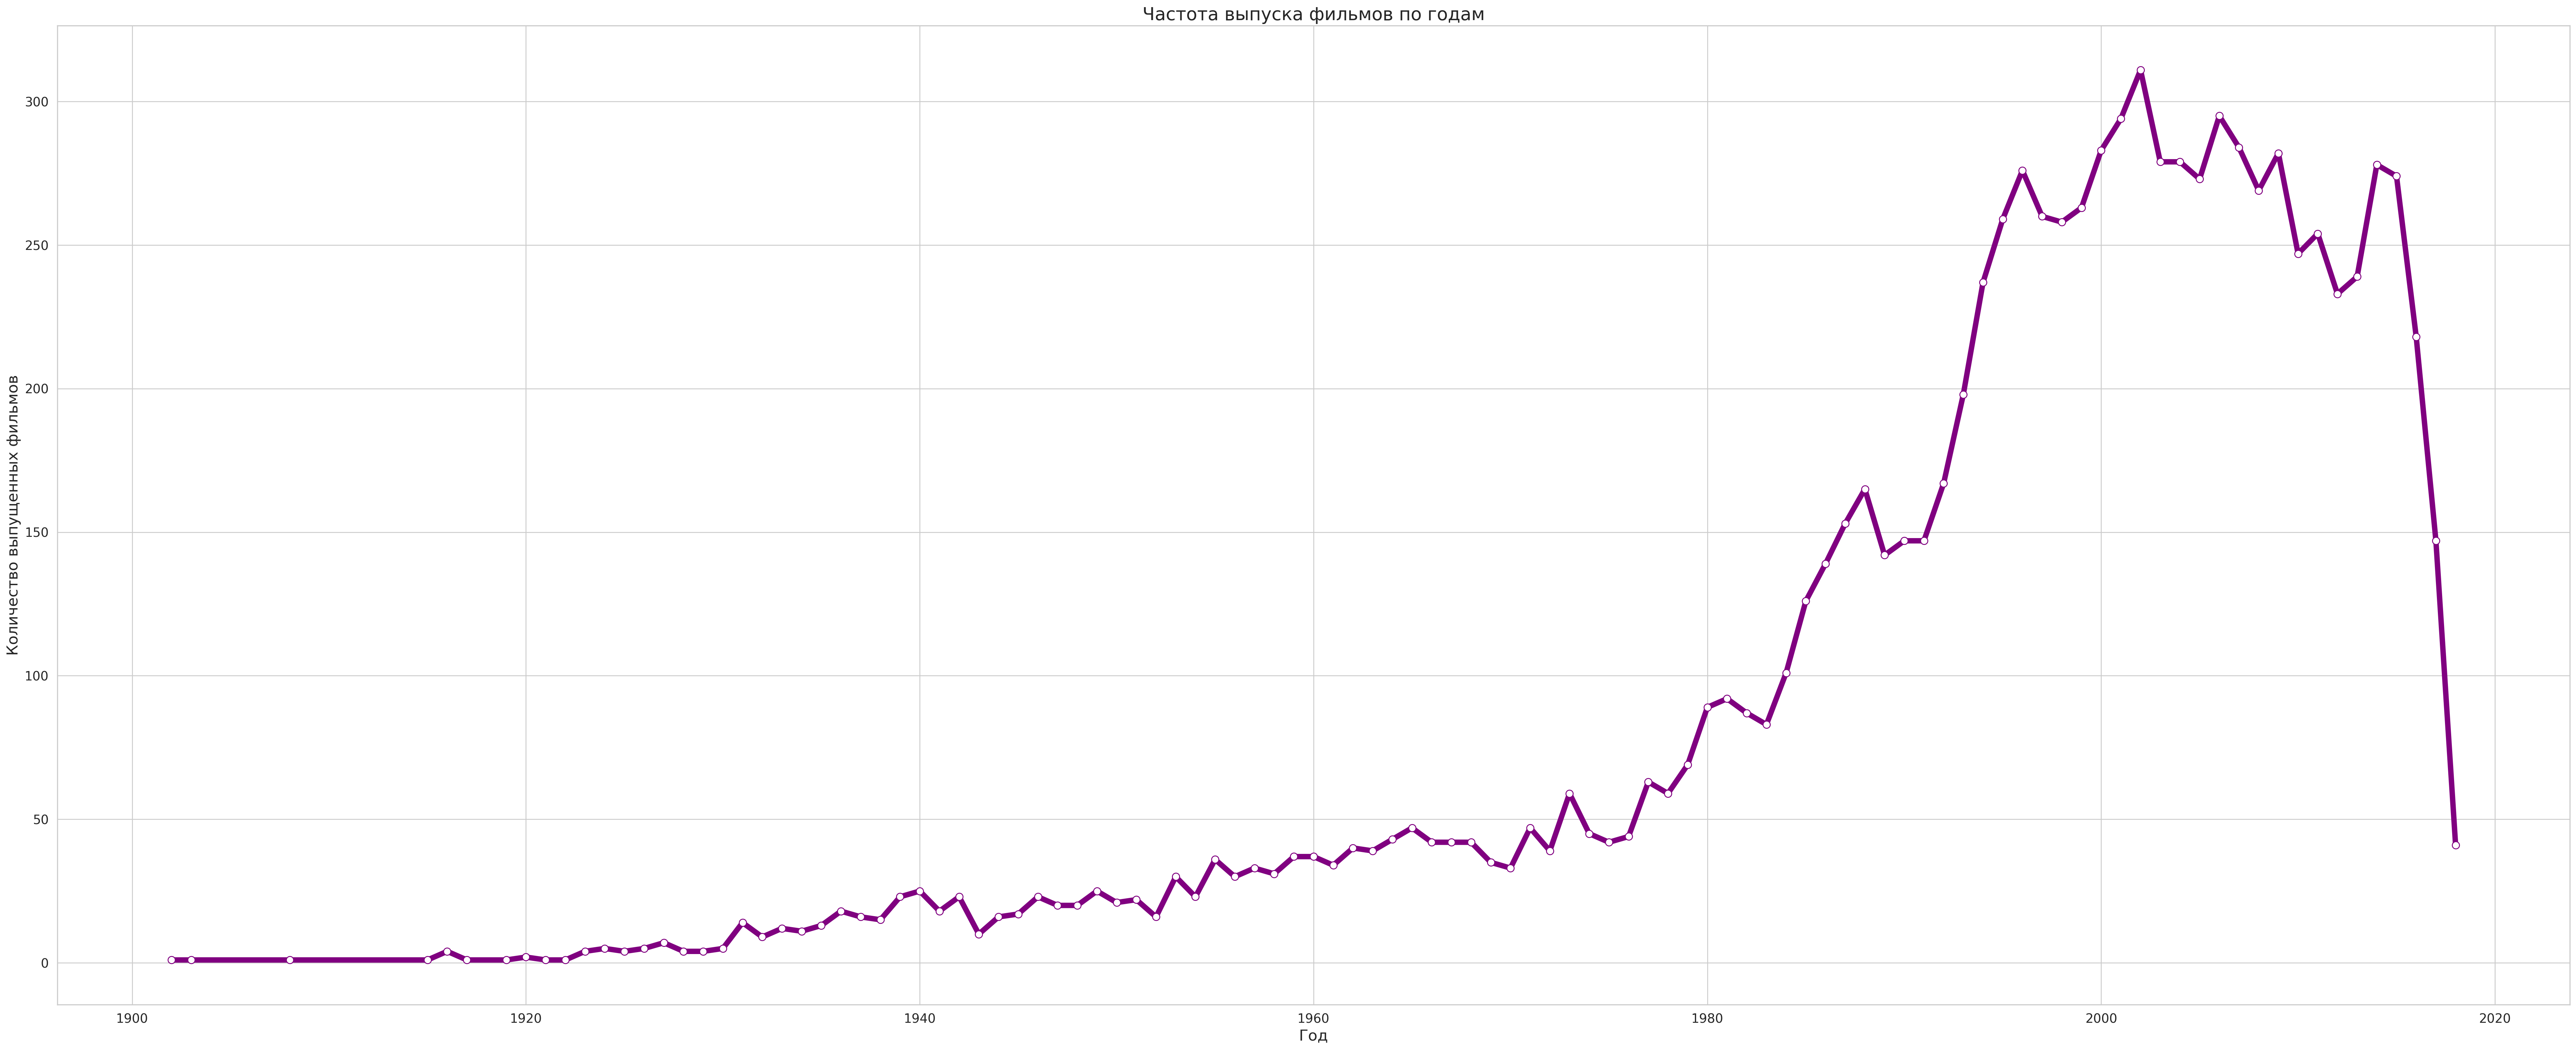

In [38]:
movies_byyear = movies_df[['movieId', 'year']].groupby('year')

fig, axes = plt.subplots(1, 1, figsize=(50, 20), dpi=200)

marker_style = dict(c="purple",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')

plt.plot(movies_byyear.year.first(), movies_byyear.movieId.nunique(),**marker_style)
plt.tick_params(labelsize = 14)

axes.set_xlabel('Год', fontsize=17)
axes.set_ylabel('Количество выпущенных фильмов', fontsize=17);
plt.title('Частота выпуска фильмов по годам', fontsize=20);
plt.show();

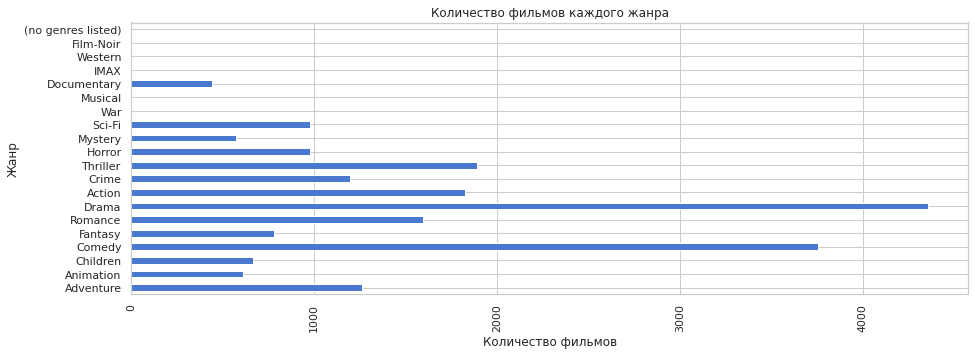

In [39]:
df_movieyear = movies_df[['movieId', 'year']].groupby('year')
df = pd.DataFrame()

for genre in genres_unique.genre:
    df_movieyear = movies_df[movies_df[genre]][['movieId', 'year']].groupby('year')
    df[genre]=df_movieyear.movieId.nunique().cumsum()

blue, = sns.color_palette("muted", 1)

plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.barh(color=blue)
plt.xticks(rotation='vertical')
plt.title('Количество фильмов каждого жанра')
plt.xlabel('Количество фильмов')
plt.ylabel('Жанр')
plt.show()

In [40]:
movies_df.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [41]:
movies_df = pd.read_csv('movies.csv')
movies_df.genres = movies_df.genres.str.split('|')
movies_df = movies_df.explode('genres')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [0]:
movies_df['year'] = movies_df.title.str.extract("\((\d{4})\)", expand=True)
movies_df.year = pd.to_datetime(movies_df.year, format='%Y')
movies_df.year = movies_df.year.dt.year 
movies_df.title = movies_df.title.str[:-7]

In [43]:
import time
ratings_df = pd.read_csv('ratings.csv')
ratings_df['timestamp'] = ratings_df['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000


In [44]:
ratings_df = ratings_df.merge(movies_df, left_on='movieId', right_on='movieId', how='inner')
ratings_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,2000,Toy Story,Adventure,1995.0
1,1,1,4.0,2000,Toy Story,Animation,1995.0
2,1,1,4.0,2000,Toy Story,Children,1995.0
3,1,1,4.0,2000,Toy Story,Comedy,1995.0
4,1,1,4.0,2000,Toy Story,Fantasy,1995.0


In [45]:
movies_df.genres.unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [46]:
mean_ratings = ratings_df.groupby(['timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)
mean_ratings.rename(columns={'timestamp': 'year'}, inplace=True) 
mean_ratings.head(30)

,year,genres,rating
0,1996,Action,3.434318
1,1996,Adventure,3.503770
2,1996,Animation,3.753501
3,1996,Children,3.567143
4,1996,Comedy,3.425333
5,1996,Crime,3.532840
6,1996,Documentary,4.176471
7,1996,Drama,3.691422
8,1996,Fantasy,3.509058
9,1996,Film-Noir,3.222222


In [47]:
ratings_bygenre = ratings_df.groupby(['genres'], as_index=False)['rating'].aggregate(np.mean)
ratings_bygenre.head()

,genres,rating
0,(no genres listed),3.489362
1,Action,3.447984
2,Adventure,3.508609
3,Animation,3.629937
4,Children,3.412956


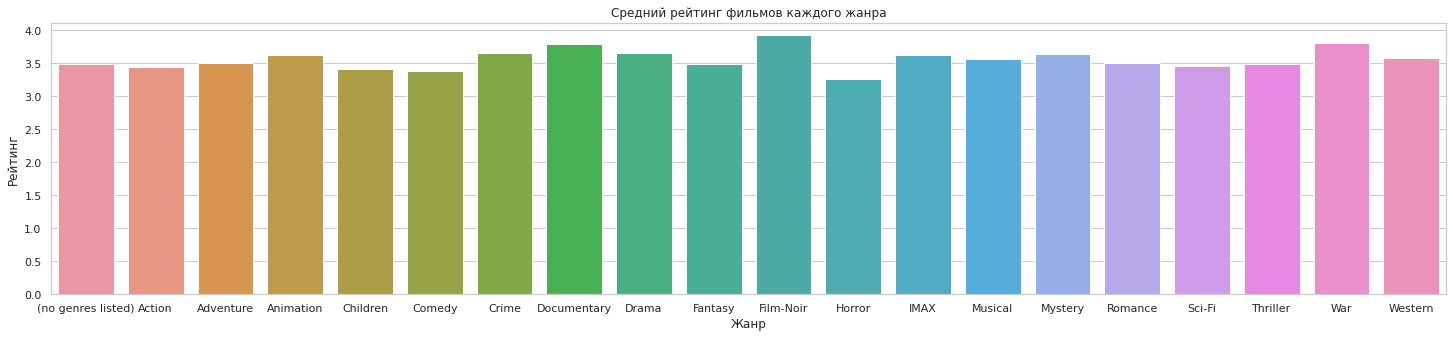

In [48]:
sns.set(style="whitegrid")

plt.figure(figsize=(25,5))
ax = sns.barplot(x="genres", y="rating", data=ratings_bygenre)

plt.title('Средний рейтинг фильмов каждого жанра')
plt.xlabel('Жанр')
plt.ylabel('Рейтинг')
plt.show();

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures hav

<Figure size 288x288 with 0 Axes>

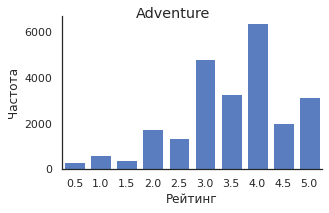

<Figure size 288x288 with 0 Axes>

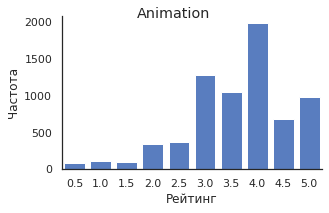

<Figure size 288x288 with 0 Axes>

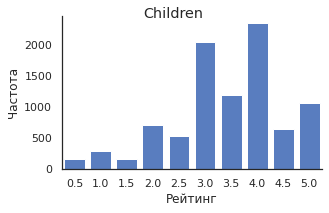

<Figure size 288x288 with 0 Axes>

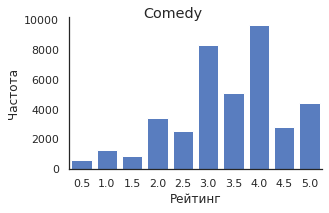

<Figure size 288x288 with 0 Axes>

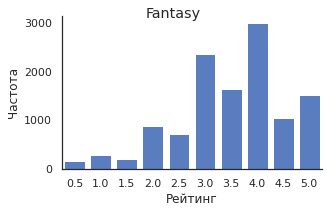

<Figure size 288x288 with 0 Axes>

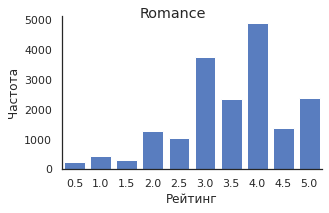

<Figure size 288x288 with 0 Axes>

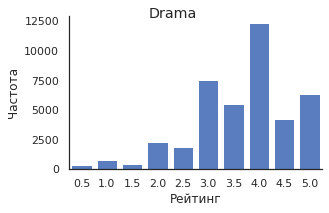

<Figure size 288x288 with 0 Axes>

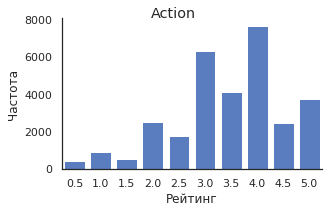

<Figure size 288x288 with 0 Axes>

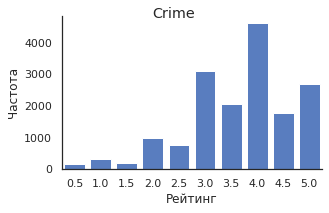

<Figure size 288x288 with 0 Axes>

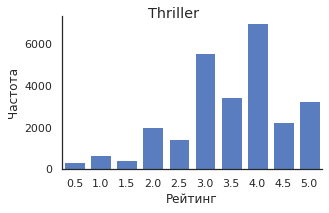

<Figure size 288x288 with 0 Axes>

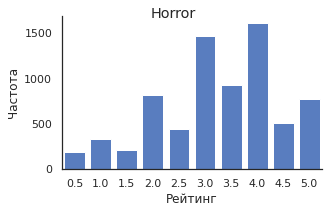

<Figure size 288x288 with 0 Axes>

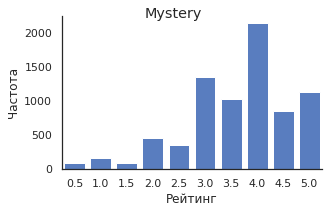

<Figure size 288x288 with 0 Axes>

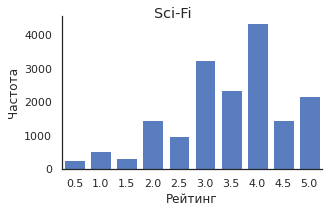

<Figure size 288x288 with 0 Axes>

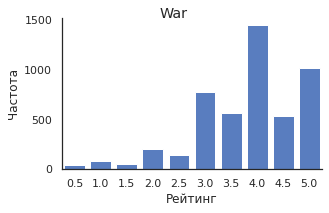

<Figure size 288x288 with 0 Axes>

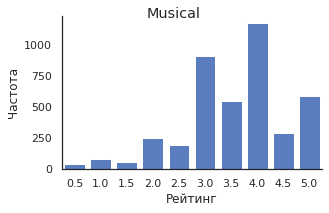

<Figure size 288x288 with 0 Axes>

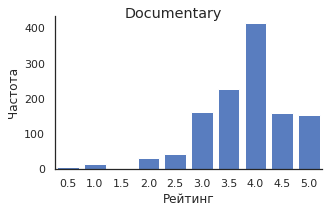

<Figure size 288x288 with 0 Axes>

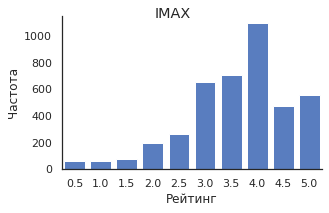

<Figure size 288x288 with 0 Axes>

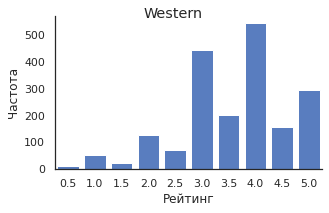

<Figure size 288x288 with 0 Axes>

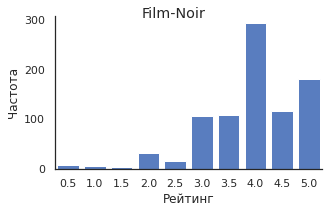

<Figure size 288x288 with 0 Axes>

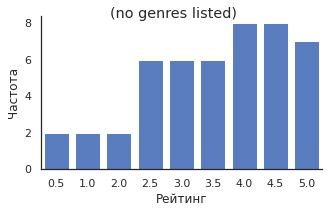

In [49]:
genres = movies_df.genres.unique().tolist()
with sns.axes_style('white'):
  for gnr in genres:
    plt.figure(figsize=(4,4));
    g = sns.factorplot("rating", data=ratings_df[ratings_df.genres == gnr], 
                       kind="count", size=3, aspect=1.5, color=blue);
    g.set_ylabels('Частота');
    g.set_xlabels('Рейтинг');
    g.fig.suptitle(gnr);

In [50]:
ratings_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,2000,Toy Story,Adventure,1995.0
1,1,1,4.0,2000,Toy Story,Animation,1995.0
2,1,1,4.0,2000,Toy Story,Children,1995.0
3,1,1,4.0,2000,Toy Story,Comedy,1995.0
4,1,1,4.0,2000,Toy Story,Fantasy,1995.0


In [51]:
ratings2 = ratings_df.groupby(['movieId', 'timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)
ratings2.head()

,movieId,timestamp,genres,rating
0,1,1996,Adventure,4.151515
1,1,1996,Animation,4.151515
2,1,1996,Children,4.151515
3,1,1996,Comedy,4.151515
4,1,1996,Fantasy,4.151515


In [52]:
pivot_genres_years = pd.pivot_table(data=ratings2, index='timestamp', columns = "genres", values='rating', aggfunc='mean')
pivot_genres_years.head()

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
timestamp,,,,,,,,,,,,,,,,,,,,
1996,NaN,3.431375,3.553743,3.642930,3.372061,3.398973,3.427006,4.152778,3.550940,3.484033,2.958333,3.470922,3.882076,3.556810,3.462948,3.467301,3.379648,3.481899,3.759949,3.409855
1997,NaN,3.643334,3.595736,3.423593,3.317951,3.624261,3.718189,3.944444,3.732190,3.660204,3.000000,3.356720,4.111111,3.607494,3.726366,3.652499,3.432635,3.557952,4.087500,3.921569
1998,NaN,3.160519,3.305195,3.461538,3.000000,3.485294,3.455172,NaN,3.633457,3.375000,3.750000,3.204444,3.777778,4.076923,3.585938,3.747585,2.965315,3.085908,4.053571,3.500000
1999,NaN,3.427124,3.675290,3.751316,3.631167,3.645941,3.653323,3.608333,3.738119,3.679916,4.236111,3.015385,4.281250,3.689124,3.699233,3.677996,3.548034,3.404093,3.957749,3.701323
2000,NaN,2.967943,3.120610,3.451738,2.929583,3.046716,3.367224,3.784314,3.491753,3.083219,3.983134,2.686339,4.212727,3.526388,3.420490,3.344649,2.891553,3.053854,3.665813,3.483919


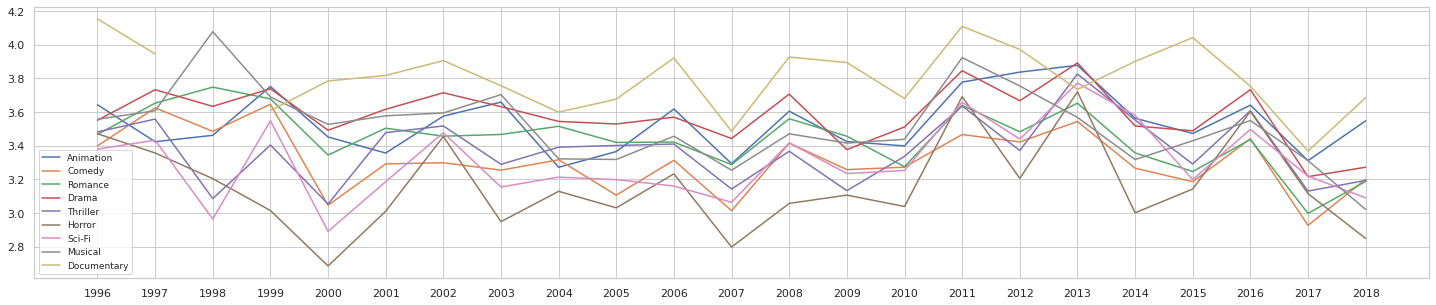

In [53]:
plt.figure(figsize=(25,5))
major_genres = ['Animation', 'Comedy', 'Romance', 'Drama', 'Thriller', 'Horror','Sci-Fi', 'Musical', 'Documentary']
for gnr in major_genres:
  plt.plot(pivot_genres_years.index, pivot_genres_years[gnr].values);

plt.legend(major_genres, loc='best', fontsize=9);

Наблюдения и выводы:
* 2002 год оказался рекордным по выпуску фильмов (более 300 выпущенных кинолент).
* Чаще всего фильмы относят к 2 жанрам: комедия и драма.
* Фильмы жанра нуар, ленты о войне и документальные фильмы получают самые высокие средние рейтинги. У фильмов ужасов самый низкий средний рейтинг (< 3.25), также невысокие рейтинги у комедий и фильмов для детей.
* Распределения оценок фильмов всех жанров схожи, скошенны вправо, т.е. пользователи не выставляют очень низкие оценки, в основном 3.0-5.0.
* У документальных фильмов в течение рассматриваемого временного периода регулярно были самые высокие рейтинги.
* Заметны резкие скачки рейтингов фильмов в 90-х, особенно касается мюзиклов, sci-fi и триллеров.

# IMDb Scraping for Plots

In [68]:
!pip install imdbpy

     |████████████████████████████████| 296kB 2.7MB/s 


In [0]:
from imdb import IMDb

ia = IMDb()

In [0]:
%%time
plots_dic = {}

import warnings
from imdb import IMDbDataAccessError

for movie_id in movies:
  row = links_df.loc[links_df['movieId'] == movie_id]
  try:
    movie = ia.get_movie(str(int(row.imdbId)), info=['plot'])
    plots_dic[movie_id] = movie.get('plot')
  except IMDbDataAccessError:
    warnings.warn('Unable to execute a search: %s')
    plots_dic[movie_id] = []

In [0]:
with open("imdb_dic_movie_plots.pickle", "wb") as fp:   
  pickle.dump(plots_dic, fp)

files.download('imdb_dic_movie_plots.pickle')

In [0]:
plots_dic_ = {}

with open('imdb_dic_movie_plots.pickle', "rb") as f:
    plots_dic_ = pickle.load(f)

In [0]:
plots_dic_[1]

In [0]:
len(plots_dic_)

In [0]:
plots_strings_dic = {}

for k, v in plots_dic_.items():
  if v is None:
    plots_strings_dic[k] = ""
  else:
    res=""
    for line in v:
      sep = "::"
      res += " " + line.split(sep, 1)[0]
    plots_strings_dic[k] = res

plots_strings_dic[1]

In [0]:
with open("plots_strings_dic.pickle", "wb") as fp:   
  pickle.dump(plots_strings_dic, fp)

files.download('plots_strings_dic.pickle')

In [0]:
with open('plots_strings_dic.pickle', "rb") as f:
    plots_strings_dic = pickle.load(f)

# Processing Plots

In [23]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(33)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def lemmatize_stemming(text):
    return SnowballStemmer(language='english').stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [0]:
plots_processed_dic = {k: preprocess(v) for k, v in plots_strings_dic.items()}

In [0]:
len(plots_processed_dic)

9724

In [0]:
plots_processed_dic = {k: " ".join(word for word in v) for k, v in plots_processed_dic.items()}

In [0]:
plots_processed_dic[1]

'cowboy doll profound threaten jealous spaceman figur supplant room littl name andi love room play toy especi doll name woodi toy andi come life woodi believ life good worri andi famili move woodi know andi birthday parti woodi realiz andi mother give action figur know buzz lightyear believ quick andi favorit woodi consum jealousi tri buzz woodi buzz lose andi move pass ruthless killer phillip woodi good heart cowboy doll belong young name andi see posit andi favorit jeopard buy buzz lightyear action figur wors arrog buzz think real spaceman mission return home planet andi famili move hous woodi buzz escap clutch maladjust neighbor phillip reunit stori secret life toy peopl buzz lightyear space ranger take woodi place andi favorit woodi like situat get fight buzz accidentali buzz fall window woodi accus toy have kill hous look return andi room outsid kind troubl tri home imagin run rampant toy mobil watch toy woodi buzz lightyear despis like toy separ home truce form effort journey hom

In [0]:
with open("plots_processed_dic.pickle", "wb") as fp:   #Pickling
  pickle.dump(plots_processed_dic, fp)

files.download('plots_processed_dic.pickle')

In [0]:
with open('plots_processed_dic.pickle', "rb") as f:
    plots_processed_dic = pickle.load(f)

# Plots to TF, Latent Dirichlet Allocation

In [0]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(plots_processed_dic.values())
tf_feature_names = tf_vectorizer.get_feature_names()

In [54]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.6MB/s 


In [59]:
tf

<9724x19558 sparse matrix of type '<class 'numpy.int64'>'
	with 816466 stored elements in Compressed Sparse Row format>

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 38.5671
Function value obtained: 113.0936
Current minimum: 113.0936
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 39.1596
Function value obtained: 145.7524
Current minimum: 113.0936
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 29.5900
Function value obtained: 94.6131
Current minimum: 94.6131
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 36.1591
Function value obtained: 146.2772
Current minimum: 94.6131
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 43.5869
Function value obtained: 204.0106
Current minimum: 94.6131
Iteration No: 

MessageError: ignored

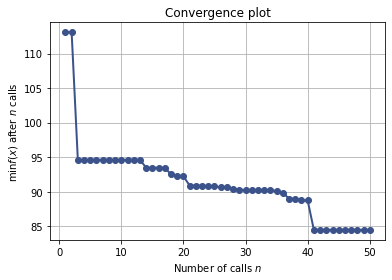

In [0]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import time

def objective(params):
  
    max_df, min_df, max_features, n_components, learning_decay, doc_topic_prior, topic_word_prior, batch_size = params
    
    tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(plots_processed_dic.values())
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda_ = LatentDirichletAllocation(n_components = n_components,           
                                learning_method = 'online',  
                                random_state = 100,
                                n_jobs = -1,
                                doc_topic_prior = doc_topic_prior,
                                topic_word_prior = topic_word_prior,
                                learning_decay = learning_decay,
                                batch_size = batch_size)
    lda_.fit(tf)
    return lda_.perplexity(tf)


space  = [Real(0.5, 0.8,  "log-uniform", name = 'max_df'),
          Real(0.05, 0.1,  "log-uniform", name = 'min_df'),
          Integer(300, 500, name = 'max_features'),
          Integer(3, 25, name = 'n_components'),
          Real(0.1, 1.0,  "log-uniform", name = 'learning_decay'),
          Real(0.01, 0.5, "log-uniform", name = 'doc_topic_prior'),
          Real(0.01, 0.5, "log-uniform", name = 'topic_word_prior'),
          Integer(64, 256, name = 'batch_size')
         ]

res_gp = gp_minimize(objective, space, n_calls = 50, n_jobs = -1, random_state = 0, verbose = True)

print('Best perplexity = {:.1f}'.format(res_gp.fun))

from skopt.plots import plot_convergence
plot_convergence(res_gp)
print(res_gp.x)

with open("opt_params_lda.pickle", "wb") as fp:   #Pickling
  pickle.dump(res_gp.x, fp)

files.download('opt_params_lda.pickle')

In [15]:
opt_max_df, opt_min_df, opt_max_features, opt_n_components, opt_learning_decay, opt_doc_topic_prior, opt_topic_word_prior, opt_batch_size = res_gp.x
    
tf_vectorizer = CountVectorizer(max_df=opt_max_df, min_df=opt_min_df, max_features=opt_max_features, stop_words='english')
tf = tf_vectorizer.fit_transform(plots_processed_dic.values())
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=opt_n_components, learning_decay=opt_learning_decay, 
                                doc_topic_prior=opt_doc_topic_prior, topic_word_prior=opt_topic_word_prior,
                                batch_size=opt_batch_size, random_state=0).fit(tf)

NameError: ignored

In [0]:
# [0.8, 0.1, 500, 25, 0.21833276421454334, 0.49999999999999994, 0.01, 256]
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=0.1, max_features=500, stop_words='english')
tf = tf_vectorizer.fit_transform(plots_processed_dic.values())
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=25, learning_decay=0.21833276421454334, 
                                doc_topic_prior=0.49999999999999994, topic_word_prior=0.01,
                                batch_size=256, random_state=0).fit(tf)

In [61]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
polic american forc attempt lead tri bring danger know includ
Topic 1:
father brother return leav live home learn tri young tell
Topic 2:
school high girl friend best like turn learn thing think
Topic 3:
film start follow make includ lead think tri thing final
Topic 4:
kill murder dead death know tri mysteri believ peopl tell
Topic 5:
famili daughter home live come tri forc bring learn leav
Topic 6:
person death begin lose peopl lead relationship feel believ live
Topic 7:
citi meet travel live mysteri chang fight begin leav soon
Topic 8:
mother life good live chang feel young long tri relationship
Topic 9:
power face forc know danger bring turn young come save
Topic 10:
work help save world tri forc break turn know stop
Topic 11:
team head bring lead forc danger turn includ play know
Topic 12:
town small local dead leav arriv turn tri bring return
Topic 13:
discov secret send arriv soon mysteri learn meet young bring
Topic 14:
life like friend play look best make live includ w

In [0]:
lda_output = lda.transform(tf)

In [29]:
lda_output = scipy.sparse.csr_matrix(lda_output)
lda_output

<9724x25 sparse matrix of type '<class 'numpy.float64'>'
	with 243100 stored elements in Compressed Sparse Row format>

# Visualizing Topic Models

In [63]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 42.5MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=9fa456c227d8b603b68f6b9d4b50d45f7a57765db036f6086b72a2539eb5c74b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=2f7af38d8f31ce88a4f899665501c288554d87ce9dbf5232f03c3f7ef61f5b0b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [67]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import os
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(25))

if 1 == 1:
  LDAvis_prepared = sklearn_lda.prepare(lda, tf, tf_vectorizer)
with open(LDAvis_data_filepath + '.pickle', 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
        
with open(LDAvis_data_filepath + '.pickle', 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(25) +'.html')

CPU times: user 5.57 s, sys: 27.7 ms, total: 5.59 s
Wall time: 7.59 s


# IMDb Scraping for People

In [0]:
people_dic = {}

import warnings
from imdb import IMDbDataAccessError

from tqdm import tqdm_notebook as tqdm

for movie_id in tqdm(movies):
  row = links_df.loc[links_df['movieId'] == movie_id]
  try:
    movie = ia.get_movie(str(int(row.imdbId)))
    cast = movie.get('cast')
    topActors = 5
    people_dic[movie_id] = "%".join(actor['name'] for actor in cast[:topActors])
  except (IMDbDataAccessError, TypeError):
    warnings.warn('Unable to execute a search: %s')
    people_dic[movie_id] = ""

In [0]:
with open("movie_people_strings_dic.pickle", "wb") as fp:   
  pickle.dump(people_dic, fp)

files.download('movie_people_strings_dic.pickle')

In [0]:
with open('movie_people_strings_dic.pickle', "rb") as f:
    people_dic = pickle.load(f)

In [14]:
people_dic[1]

'Tom Hanks%Tim Allen%Don Rickles%Jim Varney%Wallace Shawn'

In [13]:
people_strings = []
for line in people_dic.values():
  people_strings.append(line.replace('%', ' '))

people_strings[:3]

['Tom Hanks Tim Allen Don Rickles Jim Varney Wallace Shawn',
 'Walter Matthau Jack Lemmon Sophia Loren Ann-Margret Burgess Meredith',
 'Al Pacino Robert De Niro Val Kilmer Jon Voight Tom Sizemore']

In [0]:
people_vectorizer = CountVectorizer(lowercase=False)
tf_people = people_vectorizer.fit_transform(people_strings)
tf_people_feature_names = people_vectorizer.get_feature_names()

In [16]:
tf_people

<9724x18343 sparse matrix of type '<class 'numpy.int64'>'
	with 97792 stored elements in Compressed Sparse Row format>

# Matrices

In [30]:
users = list(np.sort(ratings_df.userId.unique())) 
movies = list(ratings_df.movieId.unique()) 
rating = list(ratings_df.rating) 

from pandas.api.types import CategoricalDtype
rows = ratings_df.userId.astype(CategoricalDtype(categories=users)).cat.codes
cols = ratings_df.movieId.astype(CategoricalDtype(categories=movies)).cat.codes

user_item = scipy.sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))
user_item

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [31]:
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
sparsity

98.30003169443864

In [32]:
user_item = user_item.tocoo()
user_item

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in COOrdinate format>

In [33]:
ids_to_drop = [1076,2939,3338,3456,4194,5721,6668,6849,7020,7792,8765,25855,26085,30892,32160,32371,34482,85565]

metadata = movies_df[['movieId']]
print(metadata.shape)

for i, row in metadata.iterrows():
  if row.movieId in ids_to_drop:
    metadata.drop(i, inplace=True)

print(metadata.shape)


metadata = metadata.rename(columns={'movieId': 'MOVIEID'})
metadata.head(2)

(9742, 1)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(9724, 1)


,MOVIEID
0,1
1,2


In [34]:
metadata = pd.merge(metadata, movies_df, left_on='MOVIEID', right_on='movieId', how='left').drop('movieId', axis=1)
metadata.shape

(9724, 3)

In [35]:
indices = pd.Series(metadata.index, index=metadata['title'])
metadata.head()

,MOVIEID,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Process Genres & Titles

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_genres = tfidf.fit_transform(metadata.genres)

from sklearn.metrics.pairwise import linear_kernel
cosine_sim_genres = linear_kernel(tfidf_genres, tfidf_genres)

In [0]:
def clean_movie_title(movie_title):
    if movie_title.split(" ")[-1].startswith("("):
        # remove year from the title, e.g. Toy Story (1995) --> Toy Story
        movie_title = (" ".join(movie_title.split(" ")[:-1])).strip()

    if movie_title.title().split(',')[-1].strip() in ['The', 'A']:
        # article + movie title, e.g. Saint, The --> The Saint
        movie_title = (movie_title.title().split(',')[-1].strip() + " " + " ".join(movie_title.title().split(',')[:-1])).strip()

    # otherwise, it was converting The Devil's Advocate to The Devil'S Advocate
    movie_title = movie_title.lower()
    return movie_title

In [38]:
metadata['year'] = metadata.title.str.extract("\((\d{4})\)", expand=True)
metadata.year = pd.to_datetime(metadata.year, format='%Y')
metadata.year = metadata.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
metadata.title = metadata.title.str[:-7]
metadata["title_clean"] = metadata["title"].apply(lambda row : clean_movie_title(row))
metadata.tail()

,MOVIEID,title,genres,year,title_clean
9719,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017.0,black butler: book of the atlantic
9720,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017.0,no game no life: zero
9721,193585,Flint,Drama,2017.0,flint
9722,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018.0,bungo stray dogs: dead apple
9723,193609,Andrew Dice Clay: Dice Rules,Comedy,1991.0,andrew dice clay: dice rules


In [39]:
metadata.title.values[:3]

array(['Toy Story', 'Jumanji', 'Grumpier Old Men'], dtype=object)

In [40]:
titles_processed = [preprocess(t) for t in metadata['title_clean'].values]
titles_processed[:5]

[['stori'], ['jumanji'], ['grumpier'], ['wait', 'exhal'], ['father', 'bride']]

In [41]:
titles_processed = [" ".join(word for word in l) for l in titles_processed]
titles_processed[:5]

['stori', 'jumanji', 'grumpier', 'wait exhal', 'father bride']

In [42]:
metadata = metadata.join(metadata.pop('genres').str.get_dummies('|'))
metadata.head()

,MOVIEID,title,year,title_clean,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,toy story,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995.0,jumanji,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995.0,grumpier old men,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995.0,waiting to exhale,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995.0,father of the bride part ii,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
genres_mtrx = metadata.iloc[ :, 4:].head()

In [0]:
# genres_df = metadata['genres'].str.get_dummies('|')
# genres_mtrx = scipy.sparse.csr_matrix(genres_df.values)
# genres_mtrx

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(lowercase=False, max_df=0.95, min_df=2)
titles_tfidf = tfidfvectorizer.fit_transform(titles_processed)
titles_tfidf[0]

<1x2570 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [45]:
metadata.year.values.shape

(9724,)

In [0]:
years = scipy.sparse.csr_matrix(metadata[['year']].values)

In [0]:
item_features_wgenres = scipy.sparse.hstack([lda_output, tfidf_genres, titles_tfidf, tf_people], format="csr")

In [58]:
item_features_wgenres

<9724x21115 sparse matrix of type '<class 'numpy.float64'>'
	with 391481 stored elements in Compressed Sparse Row format>

# LightFM

In [49]:
!pip install lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

     |████████████████████████████████| 307kB 3.4MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707644 sha256=0fa8a816e2a139d70c7483d29876f28487232c6b46a2017229acd972d2b4f139
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [0]:
train, test = cross_validation.random_train_test_split(user_item, test_percentage=0.25)

In [0]:
train, validation = cross_validation.random_train_test_split(train, test_percentage=0.2)

In [61]:
train.shape

(610, 9724)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 337.0107
Function value obtained: -0.5041
Current minimum: -0.5041
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 138.5534
Function value obtained: -0.8548
Current minimum: -0.8548
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 61.6519
Function value obtained: -0.8697
Current minimum: -0.8697
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 165.3820
Function value obtained: -0.4980
Current minimum: -0.8697
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 99.9143
Function value obtained: -0.4979
Current minimum: -0.8697
Iteration No: 6 s

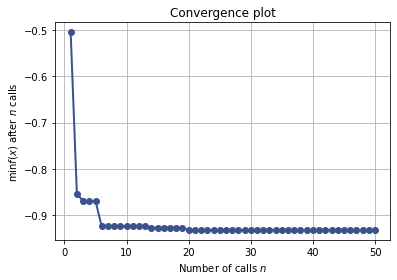

In [69]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import time


def objective(params):
    no_components, learning_rate, epochs = params
    
    lightfm = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=learning_rate,
                   no_components=no_components)
    lightfm.fit(train, epochs=epochs,
             item_features=item_features_wgenres,
             verbose=False)
    
    patks = auc_score(lightfm, test_interactions=validation,
                                         train_interactions=train,
                                         item_features=item_features_wgenres)
    
    mapatk = np.mean(patks)
    out = -mapatk # want to minimize objective
    return out


space  = [
          Integer(3, 100, name = 'no_components'),
          Real(0.001, 1.0,  "log-uniform", name = 'learning_rate'),
          Integer(1, 100, name='epochs')
          #Real(0.0001, 0.1, 'log-uniform', name='item_alpha')
         ]

res_gp_lightfm = gp_minimize(objective,
                             space,
                             n_calls=50,
                             random_state=0,
                             verbose=True)


from skopt.plots import plot_convergence
plot_convergence(res_gp_lightfm)
print(res_gp_lightfm.x)

In [70]:
opt_no_components, opt_learning_rate, opt_epochs = res_gp_lightfm.x
print(res_gp_lightfm.x)
print(res_gp_lightfm.fun)

[100, 0.005606255495499015, 100]
-0.93260914


In [0]:
train, test = cross_validation.random_train_test_split(user_item, test_percentage=0.25)

In [73]:
opt_model_all = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_learning_rate,
                   no_components=opt_no_components)

opt_model_all.fit(train, item_features=item_features_wgenres, epochs=opt_epochs)

In [74]:
all_opt_auc = auc_score(opt_model_all, test,
                                             item_features=item_features_wgenres,
                                             train_interactions=train
                                             ).mean()
print("All Features Optimal AUC: " + str(all_opt_auc))

All Features Optimal AUC: 0.9376497


In [75]:
def recommend(model, user_id):
  n_users, n_items = train.shape

  best_rated = ratings_df[(ratings_df.userId == user_id) & (ratings_df.rating >= 4.5)].nlargest(10, 'rating').movieId.values

  #known_positives = metadata['title'][train.tocsr()[user_id].indices]

  known_positives = metadata.loc[metadata['MOVIEID'].isin(best_rated)].title_clean.values
  


  scores = model.predict(user_id, np.arange(n_items), item_features=item_features_wgenres) # plots_lda_csr
  top_items = metadata['title_clean'][np.argsort(-scores)]

  print("User %s likes:" % user_id)
  for k in known_positives[:10]:
    print(k)

  print("\nRecommended:")
  for x in top_items[:10]:
    print(x)

recommend(opt_model_all, 10)

User 10 likes:
troy
the notebook
first daughter
batman begins
casino royale
the holiday
education, an
despicable me
the king's speech
the dark knight rises

Recommended:
sleepless in seattle
true romance
super mario bros.
tom and huck
othello
richard iii
tommy boy
mortal kombat
casino
four rooms


In [76]:
train_precision = precision_at_k(opt_model_all, train, k=10, item_features=item_features_wgenres).mean()
test_precision = precision_at_k(opt_model_all, test, k=10, item_features=item_features_wgenres, train_interactions=train).mean()

train_auc = auc_score(opt_model_all, train, item_features=item_features_wgenres).mean()
test_auc = auc_score(opt_model_all, test, item_features=item_features_wgenres, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.50, test 0.30.
AUC: train 0.98, test 0.94.


In [77]:
# Without actors

item_features_without_actors = scipy.sparse.hstack([lda_output, tfidf_genres, titles_tfidf], format="csr")

lightfm_without_actors = LightFM(loss='warp', no_components=100, learning_rate=0.01)

lightfm_without_actors.fit(train, item_features=item_features_without_actors, epochs=100)

train_precision = precision_at_k(lightfm_without_actors, train, k=10, item_features=item_features_without_actors).mean()
test_precision = precision_at_k(lightfm_without_actors, test, k=10, item_features=item_features_without_actors, train_interactions=train).mean()

train_auc = auc_score(lightfm_without_actors, train, item_features=item_features_without_actors).mean()
test_auc = auc_score(lightfm_without_actors, test, item_features=item_features_without_actors, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.29, test 0.13.
AUC: train 0.89, test 0.85.


In [0]:
# Only LDA

lda_lightfm = LightFM(loss='warp', no_components=50, learning_rate=0.01)

lda_lightfm.fit(train, item_features=lda_output, epochs=50)

train_precision = precision_at_k(lda_lightfm, train, k=10, item_features=lda_output).mean()
test_precision = precision_at_k(lda_lightfm, test, k=10, item_features=lda_output, train_interactions=train).mean()

train_auc = auc_score(lda_lightfm, train, item_features=lda_output).mean()
test_auc = auc_score(lda_lightfm, test, item_features=lda_output, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.09, test 0.03.
AUC: train 0.67, test 0.64.


# Cosine Sim

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

plots_lda = lda.transform(tf)

cosine_sim2 = cosine_similarity(plots_lda, plots_lda)

In [0]:
cosine_sim2.shape

(9724, 9724)

In [0]:
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim2):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim2[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return metadata['title'].iloc[movie_indices]

In [0]:
get_recommendations('Batman: The Dark Knight Returns, Part 1 (2012)', cosine_sim2)

7273                                  Little Ashes (2008)
5378                                    I Am David (2003)
7773                                     Grey, The (2012)
4484                               Wait Until Dark (1967)
3891                                          1776 (1972)
4693                                  Passenger 57 (1992)
1659        Lodger: A Story of the London Fog, The (1927)
4616                                         Radio (2003)
7346                   Twilight Saga: Eclipse, The (2010)
7538    Mesrine: Public Enemy #1 (L'ennemi public n°1)...
Name: title, dtype: object

In [0]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
